In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from warnings import warn

In [33]:

### OLD CODE ###

# def compute_Cij_squared(
#         k1, k2, i, j, L1, L2, psi, L_2D, z_i, c
# ):
#     """
#     Calculate the coefficients C_ij(k) according to equation 16
#     """
#     assert 0 < psi < np.pi / 2, "Anisotropy angle must be in the range 0 < psi < pi/2. Ensure psi is in radians."

#     # Calculate the leading factor
#     leading_factor = 2 * np.pi / L1

#     def compute_E(kappa, c, L_2D, z_i):
#         """
#         Compute the energy spectrum
#         """
#         energy_spectrum = ( 
#             (c * kappa**3)
#             / ((1./L_2D**2 + kappa**2)**(7./3.))
#             * 1./(1. + (kappa * z_i)**2)
#         )
#         return energy_spectrum

#     def compute_phi_ij(k1, k2, i, j, psi):
#         """
#         Compute the spectral tensor component phi_ij at wave vector k1,k2
#         """
#         kappa = np.sqrt(2 * ((k1**2 * np.cos(psi)**2)) + (k2**2 * np.sin(psi)**2))
#         if np.isclose(kappa, 0.0):
#             return 0.0
#         E_val = compute_E(kappa, c, L_2D, z_i)

#         delta_ij = 1 if i == j else 0
        
#         trailing_factor = 0.0
#         if i == 0 and j == 0:
#             trailing_factor = delta_ij - ((k1**2) / kappa)
#         elif i == 1 and j == 1:
#             trailing_factor = delta_ij - ((k2**2) / kappa)
#         else:
#             trailing_factor = delta_ij - ((k1 * k2) / kappa)

#         return E_val / (np.pi * kappa) * trailing_factor

#     # Build integrand
#     def integrand(k2p, k1, k2, i, j):
#         # Compute phi_ij(k1, k2p)
#         phi_ij = compute_phi_ij(k1, k2p, i, j, psi)
#         # Compute sinc^2
#         sinc_term = np.sinc(
#             (k2 - k2p) * L2 / 2
#         )
#         return phi_ij * sinc_term

#     # integral bounds
#     k2p_min = k2 - (2 * np.pi / L2)
#     k2p_max = k2 + (2 * np.pi / L2)
#     result, err = integrate.quad(
#         integrand, k2p_min, k2p_max, args=(k1, k2, i, j)
#     )

#     return result * leading_factor


In [42]:
def create_domain(Nx, Ny, L1, L2):
    dx = L1 / Nx
    dy = L2 / Ny

    x_arr = np.arange(Nx) * dx
    y_arr = np.arange(Ny) * dy

    kx_arr = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dx)
    ky_arr = 2.0 * np.pi * np.fft.fftfreq(Ny, d=dy)

    kx_arr = np.fft.fftshift(kx_arr)
    ky_arr = np.fft.fftshift(ky_arr)

    return x_arr, y_arr, kx_arr, ky_arr


In [43]:
def compute_kappa(kx, ky, psi):

    cos2 = np.cos(psi)**2
    sin2 = np.sin(psi)**2

    return np.sqrt(2.0 * (kx**2) * cos2 + (ky**2) * sin2)



In [54]:
def phi_ij(kx, ky, i, j, psi, L_2D, z_i, c):
    k_sq = kx**2 + ky**2
    if np.isclose(k_sq, 0.0):
        return 0.0
    
    kappa = compute_kappa(kx, ky, psi)
    E_val = compute_E(kappa, c, L_2D, z_i)
    
    delta_ij = 1 if i == j else 0
    k_i = kx if i == 0 else ky
    k_j = ky if j == 0 else kx

    incompressible_factor = (delta_ij - (k_i * k_j / k_sq))

    return E_val / (np.pi * kappa) * incompressible_factor


In [58]:
def compute_kappa_1D(k1, psi):
    # For the 1D approach, we treat k1^2 cos^2(psi)*2 + etc. 
    # Actually, eq.(4) suggests kappa^2 = 2*k1^2*cos^2(psi) if k2=0.
    return np.sqrt(2.0*(k1**2)*(np.cos(psi)**2))

def compute_E(kappa, c, L2D, z_i):
    if kappa < 1e-12:
        return 0.0
    # eq.(9) style
    denom = (1.0/(L2D**2) + kappa**2)**(7.0/3.0)
    atten = 1.0/(1.0 + (kappa*z_i)**2)
    return c * (kappa**3) / denom * atten

def solve_for_c(sigma2, L2D, z_i):
    """
    Solve for c so that integral of E(k) from k=0..inf = sigma2.
    (1D version for demonstration.)
    """
    def integrand(k):
        return (k**3 / ((1.0/(L2D**2) + k**2)**(7.0/3.0))) * (1.0/(1.0+(k*z_i)**2))

    val, _ = integrate.quad(integrand, 0, np.inf)
    return sigma2 / val

In [67]:
def generate_2D_lowfreq_approx(Nx, Ny, L1, L2,
                               psi_degs, sigma2, L2D, z_i):
    """
    Approx approach: 
      1) compute c from sigma2
      2) for each k1, compute phi_11(k1) using e.g. E(kappa)/(pi*kappa)
         or the simpler "2D swirl" formula
      3) multiply by factor ~ 2 * pi^2 / L1
      4) randomize phases in k2
      5) iFFT => real field
    We'll do just the 'u' field for demonstration, but you can do 'v' similarly.
    """
    psi = np.deg2rad(psi_degs)
    c_val = solve_for_c(sigma2, L2D, z_i)

    dx = L1 / Nx
    dy = L2 / Ny

    kx_arr = 2.0*np.pi * np.fft.fftfreq(Nx, d=dx)
    ky_arr = 2.0*np.pi * np.fft.fftfreq(Ny, d=dy)
    kx_arr = np.fft.fftshift(kx_arr)  # sort from negative to positive
    ky_arr = np.fft.fftshift(ky_arr)

    # Print out for debugging
    print(f"min(kx)={kx_arr[0]:.6g}, max(kx)={kx_arr[-1]:.6g}")
    print(f"min(ky)={ky_arr[0]:.6g}, max(ky)={ky_arr[-1]:.6g}")

    Amp2 = np.zeros((Nx, Ny), dtype=np.float64)

    factor_16 = (2.0 * np.pi**2) / L1

    for ix in range(Nx):
        for iy in range(Ny):
            kx = kx_arr[ix]
            ky = ky_arr[iy]

            kappa = compute_kappa(kx, ky, psi)
            E_val = compute_E(kappa, c_val, L2D, z_i)
            
            if kappa < 1e-12:
                phi_11 = 0.0
            else:
                phi_11 = E_val / (np.pi * kappa)
            
            amp2_kx = factor_16 * phi_11
            Amp2[ix, iy] = amp2_kx

    Uhat = np.zeros((Nx, Ny), dtype=np.complex128)
    for ix in range(Nx):
        for iy in range(Ny):
            amp = np.sqrt(Amp2[ix, iy])
            phase = (np.random.normal() + 1j*np.random.normal()) / np.sqrt(2.0)
            Uhat[ix, iy] = amp * phase

    Uhat_unshift = np.fft.ifftshift(Uhat, axes=(0,1))
    u_field_complex = np.fft.ifft2(Uhat_unshift, s=(Nx, Ny))
    u_field = np.real(u_field_complex)

    var_now = np.var(u_field)
    if var_now > 1e-12:
        u_field *= np.sqrt(sigma2 / var_now)

    return u_field

min(kx)=-0.0536165, max(kx)=0.0535118
min(ky)=-0.0536165, max(ky)=0.0531976
min(kx)=-0.0536165, max(kx)=0.0535118
min(ky)=-0.0536165, max(ky)=0.0531976


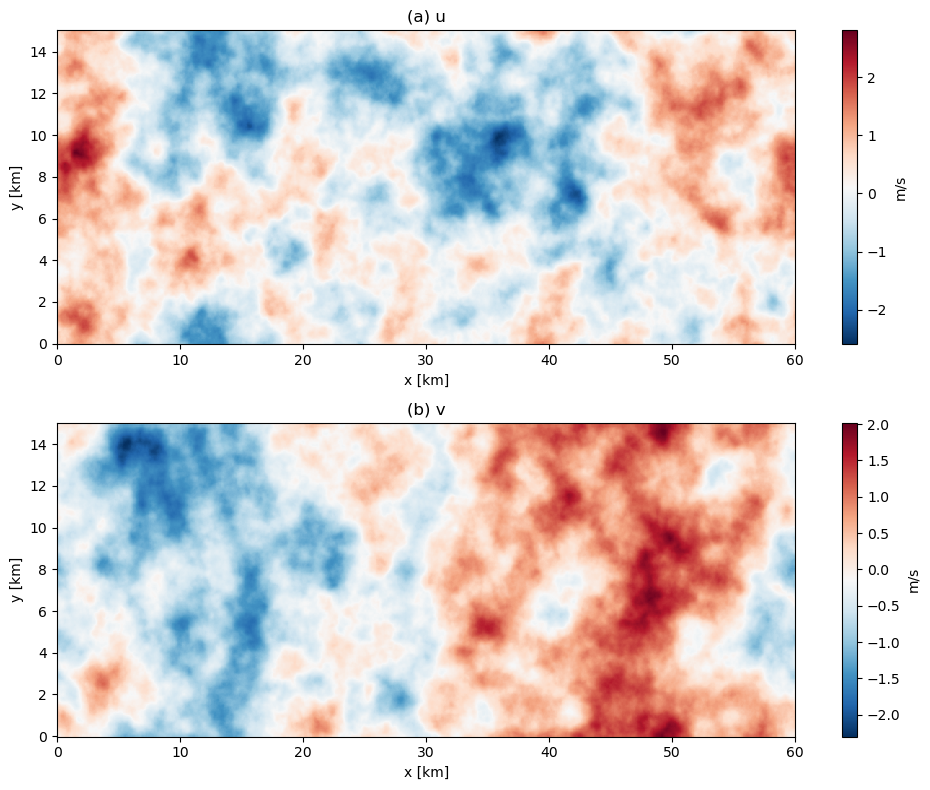

In [71]:
# Domain: 60 km x 15 km
L1 = 60_000.0
L2 = 15_000.0
Nx = 1024
Ny = 256

# Figure 3 parameters
L2D = 15000.0    # [m]
sigma2 = 0.6     # [m^2/s^2]
z_i = 500.0      # [m]
psi_degs = 43.0  # anisotropy angle

# Generate large-scale u-component
u_field = generate_2D_lowfreq_approx(Nx, Ny, L1, L2,
                                        psi_degs, sigma2, L2D, z_i)

# Generate large-scale v-component similarly
# (Here, we assume same sigma^2 and same approach.)
v_field = generate_2D_lowfreq_approx(Nx, Ny, L1, L2,
                                        psi_degs, sigma2, L2D, z_i)

# Now we have 2D arrays: u_field, v_field
# Plot them in "km" units with ~ ±1.5 m/s range
import matplotlib.pyplot as plt

x = np.linspace(0, L1/1000, Nx)  # in km
y = np.linspace(0, L2/1000, Ny)  # in km
X, Y = np.meshgrid(x, y, indexing='ij')

fig, axs = plt.subplots(2,1, figsize=(10,8))
im1 = axs[0].pcolormesh(X, Y, u_field, shading='auto', cmap='RdBu_r')
cb1 = plt.colorbar(im1, ax=axs[0], label='m/s')
axs[0].set_title('(a) u')
axs[0].set_xlabel('x [km]')
axs[0].set_ylabel('y [km]')

im2 = axs[1].pcolormesh(X, Y, v_field, shading='auto', cmap='RdBu_r')
cb2 = plt.colorbar(im2, ax=axs[1], label='m/s')
axs[1].set_title('(b) v')
axs[1].set_xlabel('x [km]')
axs[1].set_ylabel('y [km]')

plt.tight_layout()
plt.show()